### Data extraction "Joc de l'Habitatge"

In [2]:
import pymysql
import csv
import time
from datetime import datetime, date
import calendar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import scipy.stats as stats

from collections import Counter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [3]:
title_font = {'fontname': 'Helvetica', 'size': '14', 'color': 'black', 'weight': 'bold', 'verticalalignment': 'bottom'}  # Bottom vertical alignment for more space
axis_font = {'fontname': 'Helvetica', 'size': '12', 'weight': 'bold', 'color': 'black'}
ticks_font = {'fontname': 'Helvetica', 'size': '10',  'color': 'black', 'weight': 'bold'}

# Colors disseny
colors = ["#009fe3", "#20b200"]
tricolors_green = ["#8fd87f", "#20b200", "#105900"]

# Colors blanc/negre
colors = [ 'black', 'white']
bicolors = ['black', '#CCCCCC']
tricolors = ['#CCCCCC', '#888888', 'black']
tricolors_white = ['#FFFFFF', '#888888', 'black']

bicolors_black = ['black', 'black']
bicolors_white = ['white', 'white']
bicolors_grey = ['#CCCCCC', '#CCCCCC']


#### ToDo: Revise the control variables

In [4]:
def data_extraction():

    host = '127.0.0.1'
    db = pymysql.connect(user='bibliolab', passwd='bibliolab2019', host=host, db='bibliolab_olesa')

    with db:
        
        
        # Database game
        c_game = db.cursor()
        c_game.execute("SELECT GAME.id, GAME.status, GAME.experiment, GAME.control_intervention FROM game_partida GAME ")
        data_game = c_game.fetchall()

        games = []

        for g in data_game:
            
            if g[1] != 'NO_VALID': # Game status
            
                c_round = db.cursor()
                c_round.execute("SELECT ROUND.id, ROUND.num_ronda, ROUND.bucket_inici_ronda, ROUND.bucket_final_ronda, ROUND.rented, ROUND.calculada, ROUND.user_id, ROUND.increment FROM game_ronda ROUND WHERE ROUND.partida_id = %d ORDER BY ROUND.num_ronda ASC " %(g[0]))
                data_round = c_round.fetchall()

                rounds = []

                for r in data_round:
                    if r[5] == 1: # if round is calculated
                        round_ = {'id': r[0],
                                 'num_round': r[1],
                                 'price_init': r[2],
                                 'price_fini': r[3],
                                 'is_rented': r[4],
                                 'user_id': r[6],
                                 'increment': r[7],
                                 }
                        rounds.append(round_)
                        
                game = {'id': g[0],
                        'status': g[1],
                        'experiment': g[2],
                        'control_intervention': g[3],
                        'rounds': rounds
                       }
                
                if game['status'] != 'TEST':
                    games.append(game)


        # Database user
        c_user = db.cursor()
        c_user.execute("SELECT USER.id, USER.is_robot, USER.consent, USER.socio_pr1, USER.socio_pr2, USER.socio_pr3, USER.socio_pr4, USER.socio_pr5, USER.socio_pr6, USER.socio_pr7, USER.frame_pr1, USER.frame_pr2, USER.frame_pr3, USER.frame_pr4, USER.frame_pr5, USER.frame_pr6, USER.verification_attempts, USER.status, USER.acabat, USER.bots, USER.endowment_initial, USER.endowment_current, USER.endowment_final, USER.expenses, USER.tickets, USER.house, USER.house_price, USER.partida_id, USER.comment, USER.enquesta_final_pr1, USER.enquesta_final_pr2, USER.enquesta_final_pr3, USER.enquesta_final_pr4, USER.enquesta_final_pr5, USER.enquesta_final_pr6 FROM game_user USER ")
        data_user = c_user.fetchall()


        # Collect user data
        participants = []

        for u in data_user:

            control = {
                'is_robot': u[1], # is a robot?
                'consent': u[2], # is consented?
                'status': u[17], # status
                'acabat': u[18], # acabat?
                'bots': u[19], # number of bots selection
                'verification_attempts': u[16], # verification questions attemps
                'comments': u[28] # empty ("") if its all ok
            }
    
            #ToDo: Revise the control
            if control['is_robot'] == 0 and control['consent'] == 1 and control['acabat'] == 1 and control['bots'] < 2 and control['comments']=='':
            #if control['is_robot'] == 0 and control['consent'] == 1 and control['acabat'] == 1 and control['comments']!='TEST':
                
                # Round information
                c_user_round = db.cursor()
                c_user_round.execute("SELECT USER_ROUND.id, USER_ROUND.ha_seleccionat, USER_ROUND.seleccio, USER_ROUND.temps_seleccio, USER_ROUND.endowment_variation, USER_ROUND.ronda_id, USER_ROUND.user_id, ROUND.num_ronda, ROUND.bucket_inici_ronda, ROUND.user_id, ROUND.increment FROM game_userronda USER_ROUND INNER JOIN game_ronda ROUND ON ROUND.id = USER_ROUND.ronda_id WHERE USER_ROUND.user_id = %d ORDER BY USER_ROUND.ronda_id ASC " %(u[0]))
                data_user_round = c_user_round.fetchall() 

                rounds = []
                num_round_rented = None
                
                for ur in data_user_round:  
                    round_ = {'id': ur[0],
                              'num_round': ur[7],
                              'is_selected': ur[1], # round is selected?
                              'selection': ur[2], # round selection
                              'time_selection': ur[3], # time selection
                              'price': ur[8],
                              'increment': ur[10] #-1: baixa, 0: es queda igual, +1: puja
                             }

                    rounds.append(round_)
                    
                    if ur[9] == u[0] and ur[2]:
                        num_round_rented = ur[7]
                    

                socio = {'socio_pr1': u[3], # q: Identitat de gènere r1: Home; r2: Dona; r3: No binària; r4: No vull contestar;
                         'socio_pr2': u[4], # q: Rang d'edat r1: Menor de 14; r2: 14 - 17; r3: 18 - 24; r4: 25 - 34; r5: 35 - 44; r6: 45 - 54; r7: 55 - 64; r8: Major de 65;
                         'socio_pr3': u[5], # q: Codi Postal
                         'socio_pr4': u[6], # q: Nivell d'estudis finalitzats r1: Cap; r2: Obligatoris; r3: Secundaris generals; r4: Secundaris professionals; r5: Universitaris; r6: Altres;
                         'socio_pr5': u[7], # q: Amb qui vius? r1: Sol; r2: Llar sense persones a càrrec; r3: Llars amb persones a càrrec; r4: Més persones que no són parella;
                         'socio_pr6': u[8], # q: Règim de tinença de la teva llar r1: En propietat; r2: En propietat pendent de pagament (hipoteca); r3: En lloguer o relloguer a preu de mercat; r4: En lloguer o relloguer a preu inferior al de mercat ; r5: En cessió gratuïta; r6: Habitació de lloguer; r7: Ocupació; r8: Altres; 
                         'socio_pr7': u[9], # q: Ets propietari d’algun habitatge que està en règim de lloguer? r1: Sí; r2: No; r3: No vull contestar;
                        }

                frame = {'frame_pr1': u[10], # q: En quina mesura comparteixes la inquietud triada pels veïns que han participat en el co-disseny d'aquest experiment sobre el tema de l'habitatge? r1: Poc; r2: Normal; r3: Molt;
                         'frame_pr2': u[11], # q: En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? r1: Poc; r2: Normal; r3: Molt
                         'frame_pr3': u[12], # q: En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu? r1: Poc; r2: Normal; r3: Molt;
                         'frame_pr4': u[13], # q: Quin creus que és el preu mig del lloguer d’una casa de 70m2 en bones condicions a {municipi}? r1: 300 euros; r2: 400 euros; r3: 500 euros; r4: 600 euros; r5: 700 euros; r6: 800 euros; r7: 900 euros; r8: 1000 euros;
                         'frame_pr5': u[14], # q: Quin percentatge dels teus ingressos mensuals nets dediques a despeses associades a l’accés a l’habitatge? r1: <25%; r2: 25-34%; r3: 35-44%; r4: 45-54%; r5: 55-64%; r6: 65-74%; r7: >74%;
                         'frame_pr6': u[15], # q: Quin percentatge dels teus ingressos mensuals nets consideres just dedicar a despeses associades a l’accés a l’habitatge? r1: <25%; r2: 25-34%; r3: 35-44%; r4: 45-54%; r5: 55-64%; r6: 65-74%; r7: >74%;
                        }
                
                final = {'final_pr1': u[29], # q: En quina mesura creus que ha d’haver-hi un control públic de l’habitatge? 
                         'final_pr2': u[30], # q: En quina mesura estàs d’acord amb la necessitat de tenir un sistema que garanteixi la consideració de l’habitatge com un bé de primera necessitat?
                         'final_pr3': u[31], # q: En quina mesura creus que la presència de pisos buits afecta la situació de l'habitatge al municipi? 
                         'final_pr4': u[32], # q: En quina mesura estàs d’acord amb la necessitat de prioritzar el dret a l’habitatge per a col·lectius vulnerables? 
                         'final_pr5': u[33], # q: Coneixes iniciatives d’habitatge cooperatiu?
                         'final_pr6': u[34], # q: En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
                }
                

                # Participant Dictionary
                game = [g for g in games if g['id'] == u[27]][0]
                
                participant = {'id': u[0],
                               'game': game,
                               'intervention': game['control_intervention'],
                               'control': control,
                               'socio': socio,
                               'frame': frame,
                               'final': final,
                               'rounds': rounds,
                               'endowment_initial': u[20], 
                               'endowment_current': u[21],
                               'endowment_final': u[22],
                               'expenses': u[23],
                               'tickets': u[24], 
                               'house': u[25], 
                               'house_price': u[26], 
                               'round_rented': num_round_rented
                              }
                
                participants.append(participant)
        
        
    return games, participants
    

In [5]:
games, participants = data_extraction()

df_games = pd.DataFrame(games)
df_participants = pd.DataFrame(participants)

rent_OM = 1643
high_limit_OM = 655
low_limit_OM = 485

participants_TS = [p for p in participants if p['game']['experiment'] == 'Test']
participants_FP = [p for p in participants if p['game']['experiment'] == 'FortPienc']
participants_GR = [p for p in participants if p['game']['experiment'] == 'Granollers']
participants_OM = [p for p in participants if p['game']['experiment'] == 'Olesa']

df_participants_TS = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Test'])
df_participants_FP = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'FortPienc'])
df_participants_GR = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Granollers'])
df_participants_OM = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Olesa'])

df_games_TS = df_games.loc[df_games['experiment'] == 'Test']
df_games_FP = df_games.loc[df_games['experiment'] == 'FortPienc']
df_games_GR = df_games.loc[df_games['experiment'] == 'Granollers']
df_games_OM = df_games.loc[df_games['experiment'] == 'Olesa']

print '----------------------'
print 'Games and Participants'
print 'TS: ' + str(len(df_games_TS)) + '(' + str(6*len(df_games_TS)) + ' p.)' 
print 'FP: ' + str(len(df_games_FP)) + '(' + str(6*len(df_games_FP)) + ' p.)' 
print 'GR: ' + str(len(df_games_GR)) + '(' + str(6*len(df_games_GR)) + ' p.)' 
print 'OM: ' + str(len(df_games_OM)) + '(' + str(6*len(df_games_OM)) + ' p.)' 

print '------------------'
print 'Valid Participants'
print 'TS: ' + str(len(df_participants_TS))
print 'FP: ' + str(len(df_participants_FP))
print 'GR: ' + str(len(df_participants_GR))
print 'OM: ' + str(len(df_participants_OM))




----------------------
Games and Participants
TS: 0(0 p.)
FP: 0(0 p.)
GR: 0(0 p.)
OM: 27(162 p.)
------------------
Valid Participants
TS: 0
FP: 0
GR: 0
OM: 149


### Sociodemographics

In [14]:
text_dataset = 'socio_OM' 
participants = participants_OM
df_participants_socio = pd.DataFrame(list(df_participants_OM['socio']))


#### Identitat de genere

|  |socio_pr1|
|----------|
|r1| Home | 
|r2| Dona | 
|r3| No binària | 
|r4| No vull contestar |

#### Rang d'edat

|  |socio_pr2| 
|------------|
|r1| Menor de 14 | 
|r2| 14 - 17 | 
|r3| 18 - 24 | 
|r4| 25 - 34 | 
|r5| 35 - 44 | 
|r6| 45 - 54 | 
|r7| 55 - 64 | 
|r8| Major de 65|

-----
Total Participants: 149
Total Women: 73 - 0.49
Total Men:  70 - 0.47
Total Other:  6 - 0.04
-----


,label,value,per
0,<14,0,0.000000
1,14-17,0,0.000000
2,18-24,17,0.114094
3,25-34,32,0.214765
4,35-44,27,0.181208
5,45-54,34,0.228188
6,55-64,25,0.167785
7,>64,12,0.080537


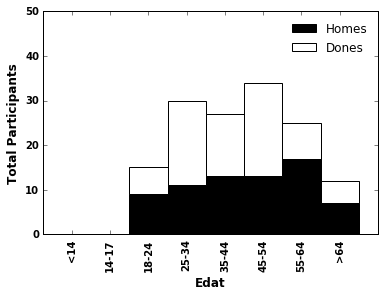

In [18]:
socio_pr2 = [p['socio']['socio_pr2'] for p in participants]

socio_pr2_women = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] == 'W']
socio_pr2_men = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] == 'M']
socio_pr2_none = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] != 'W' and p['socio']['socio_pr1'] != 'M']

print ('-----')
print ('Total Participants: %d' %(len(participants)))
print ('Total Women: %d - %.2f' %(len(socio_pr2_women), float(len(socio_pr2_women))/float(len(participants))))
print ('Total Men:  %d - %.2f' %(len(socio_pr2_men), float(len(socio_pr2_men))/float(len(participants))))
print ('Total Other:  %d - %.2f' %(len(socio_pr2_none), float(len(socio_pr2_none))/float(len(participants))))
print ('-----')


df_ages = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'], 
                         'value':[socio_pr2.count('r1'), socio_pr2.count('r2'), socio_pr2.count('r3'), 
                                  socio_pr2.count('r4'), socio_pr2.count('r5'), socio_pr2.count('r6'), 
                                  socio_pr2.count('r7'), socio_pr2.count('r8')]})

df_ages['per'] = df_ages['value']/len(participants)

df_women = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'], 
                         'value':[socio_pr2_women.count('r1'), socio_pr2_women.count('r2'), socio_pr2_women.count('r3'), 
                                  socio_pr2_women.count('r4'), socio_pr2_women.count('r5'), socio_pr2_women.count('r6'), 
                                  socio_pr2_women.count('r7'), socio_pr2_women.count('r8')]})

df_men = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'],
                       'value':[socio_pr2_men.count('r1'), socio_pr2_men.count('r2'), socio_pr2_men.count('r3'), 
                            socio_pr2_men.count('r4'), socio_pr2_men.count('r5'), socio_pr2_men.count('r6'), 
                            socio_pr2_men.count('r7'), socio_pr2_men.count('r8')]})

max_y = 10

df_gender = pd.DataFrame()
df_gender['men'] = df_men['value']
df_gender['women'] = df_women['value']

plt.clf()
fig, ax = plt.subplots()
ax = df_gender[['men', 'women']].plot.bar(stacked=True, width=1, position=0.5, ax=ax, alpha=1, color=[colors[0], colors[1]])
max_y = 50
plt.xticks(np.arange(0,9),('<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'), **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Edat', **axis_font)
plt.ylabel('Total Participants', **axis_font)
plt.legend(['Homes','Dones'], fancybox=True, framealpha=0)
plt.ylim(0,max_y)

plt.savefig('figures/Olesa/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

mapping = {'r1': float(1+13)/2, 'r2': float(14+17)/2, 'r3': float(18+24)/2, 'r4': float(25+34)/2, 'r5': float(35+44)/2, 'r6': float(45+54)/2, 'r7': float(55+64)/2, 'r8': float(65+99)/2, '': None}
df_participants_socio_numeric = df_participants_socio.replace({'socio_pr2': mapping})
df_participants_socio_numeric.describe()
df_ages


#### On vius? (CP)

| |socio_pr3|
|-----------|
|**Granollers**|08401 / 08402 / 08403 |
|**Olesa de Montserrat**| 08640 |
|**Fort Pienc**| 08013 |

#### Olesa

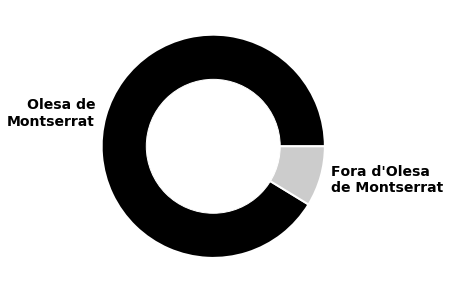

,label,value,perc
0,Olesa de\nMontserrat,136,0.912752
1,Fora de\nOlesa de\nMontserrat,13,0.087248


In [24]:
socio_pr3 = [p['socio']['socio_pr3'] for p in participants]

#########################
## Olesa de Montserrat ##
#########################

olesa = socio_pr3.count('08640') + socio_pr3.count('8640')
fora_olesa = len(socio_pr3) - olesa

df_olesa = pd.DataFrame({'label':['Olesa de\nMontserrat', 'Fora de\nOlesa de\nMontserrat'], 
                              'value':[olesa, fora_olesa]})

df_olesa['perc'] =  df_olesa['value']/len(socio_pr3)


labels = ['Olesa de\nMontserrat', 'Fora d\'Olesa\nde Montserrat']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie([olesa, fora_olesa], labels=labels, colors=bicolors,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/Olesa/02_olesa_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

df_olesa


#### Nivell d'estudis finalitzats

|  | socio_pr4 |
|------------------------------|
|r1|Cap|
|r2|Obligatoris (primària, EGB, ESO)|
|r3|Secundaris generals (batxillerat, PREU, BUP, COU)|
|r4|Secundaris professionals (comerç, FP1, FP2, mòduls, grau mitja/superior)|
|r5|Universitaris (grau, diplomatura, llicenciatura, màster, postgrau, doctorat)|
|r6|Altres|

r1     NaN
r2    21.0
r3    19.0
r4    33.0
r5    71.0
r6     3.0
Name: socio_pr4, dtype: float64

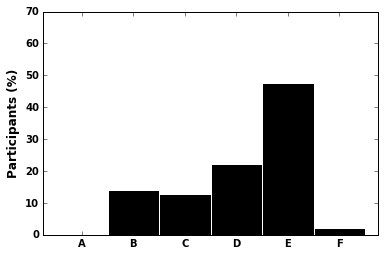

In [19]:

plt.clf()

plt_studies = df_participants_socio['socio_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
#plt_studies.set_xticklabels(['Cap', 'Obligatoris', 'Secundaris\nGenerals', 'Secundaris\nProfessionals', 'Universitaris', 'Altres'])
plt_studies.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

plt.savefig('figures/Olesa/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6']]
df_participants_socio['socio_pr4'].value_counts(normalize=False)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6']]




#### Amb qui vius?


|| socio_pr5 |
|------------|
|r1|Sol|
|r2|Llar sense persones a càrrec|
|r3|Llar amb persones a càrrec|
|r4|Més persones que no són parella|

r1    18
r2    45
r3    61
r4    22
Name: socio_pr5, dtype: int64

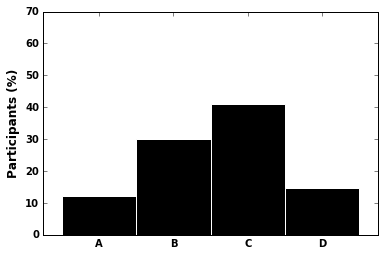

In [20]:
plt_who_lives = df_participants_socio['socio_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")

# plt_studies.get_legend().remove()
#plt_who_lives.set_xticklabels(['Sol', 'Llar sense persones\na carrec', 'Llar amb persones\na carrec', 'Mes persones que\nno son parella'])
plt_who_lives.set_xticklabels(['A', 'B', 'C', 'D'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], [0,10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

#plt.text(0, max_y - 15, 
#         'A: Sol\nB: Llar sense persones a carrec\nC: Llar amb persones a carrec\nD: Mes persones que no son parella',
#         **ticks_font)
plt.savefig('figures/Olesa/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4']]
df_participants_socio['socio_pr5'].value_counts(normalize=False)[['r1', 'r2', 'r3', 'r4']]




#### Règim de tinença de la teva llar
| |socio_pr6|
|----------|
|r1|En propietat|
|r2|En propietat pendent de pagament (hipoteca)|
|r3|En lloguer o relloguer a preu de mercat|
|r4|En lloguer o relloguer a preu inferior al de mercat|
|r5|En cessió gratuïta|
|r6|Habitació de lloguer|
|r7|Ocupació|
|r8|Altres|

In [21]:
df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', '']]
df_participants_socio['socio_pr6'].value_counts(normalize=False)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', '']]


r1    65
r2    35
r3    15
r4    16
r5     4
r6     3
r7     1
r8     7
       3
Name: socio_pr6, dtype: int64

r1    0.436242
r2    0.234899
r3    0.100671
r4    0.107383
r5    0.026846
r6    0.020134
r7    0.006711
r8    0.046980
Name: socio_pr6, dtype: float64

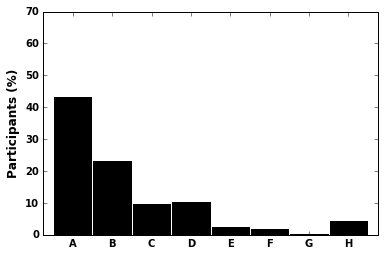

In [118]:
plt.clf()
plt_home_tenancy = df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
# plt_home_tenancy.set_xticklabels(['En propietat', 'En propietat pendent de pagament (hipoteca)', 'En lloguer o relloguer a preu de mercat', 'En lloguer o relloguer a preu inferior al de mercat', 'En cessio gratuita', 'Habitacio de lloguer', 'Ocupacio', 'Altres'])
plt_home_tenancy.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

#plt.text(0, max_y - 25, 
#         'A: En propietat\nB: En propietat pendent de pagament (hipoteca)\nC: En lloguer o relloguer a preu de mercat\nD: En lloguer o relloguer a preu inferior al de mercat\nE: En cessio gratuita\nF: Habitacio de lloguer\nG: Ocupacio\nH: Altres',
#         **ticks_font)
plt.savefig('figures/Olesa/06_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']]


#### Ets propietari d’algun habitatge que està en règim de lloguer?
||socio_pr7|
|----------|
|r1|Sí|
|r2|No|
|r3|No vull contestar|

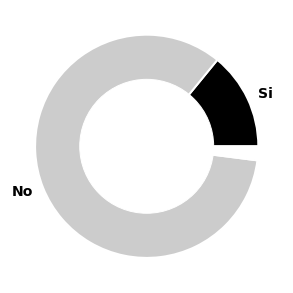

r1     21
r2    125
        3
Name: socio_pr7, dtype: int64

In [22]:
plt.clf()

freq_owner = df_participants_socio['socio_pr7'].value_counts(normalize=True)[['r1', 'r2', '']]

labels = ['Si', 'No', '']

bicolors_none = ['black', '#CCCCCC', '#FFFFFF']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie(freq_owner, labels=labels, colors=bicolors_none,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]


p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/Olesa/07_'+text_dataset+'.png', bbox_inches='tight', dpi=300)
plt.show()

freq_owner
df_participants_socio['socio_pr7'].value_counts(normalize=False)[['r1', 'r2', '']]


### Frame

In [120]:
text_dataset = 'frame_OM' 
df_participants_frame = pd.DataFrame(list(df_participants_OM['frame']))
df_participants_frame.tail()


,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6
144,r1,r3,r3,r2,r4,r3
145,r1,r2,r2,r4,r1,r1
146,r2,r3,r3,r2,r2,r1
147,r2,r3,r3,r4,r1,r1
148,r3,r3,r3,r3,r1,r3


#### Codiseny

**pr1:** En quina mesura comparteixes la inquietud triada pels veïns que han participat en el co-disseny d'aquesta recerca sobre el tema de l'habitatge?



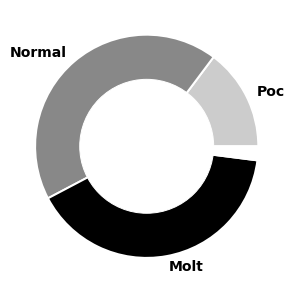

r1    0.147651
r2    0.429530
r3    0.402685
      0.020134
Name: frame_pr1, dtype: float64

In [121]:
pr1_counts = df_participants_frame['frame_pr1'].value_counts(normalize=True)[['r1', 'r2', 'r3','']]
pr1_counts=pr1_counts.fillna(0)

labels = ['Poc', 'Normal', 'Molt', '']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

tricolors_none = ['#CCCCCC', '#888888', 'black', '#FFFFFF']

patches, texts = plt.pie(pr1_counts, labels=labels, colors=tricolors_none, 
                                    wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio fiscal per ajuts', **title_font)
plt.savefig('figures/Olesa/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

pr1_counts

#### Polítiques Públiques

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|


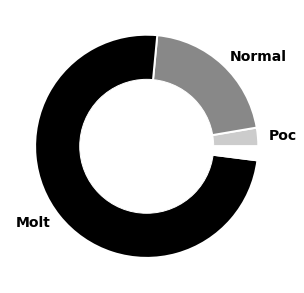

r1    0.026846
r2    0.208054
r3    0.744966
      0.020134
Name: frame_pr2, dtype: float64

In [122]:
pr2_counts = df_participants_frame['frame_pr2'].value_counts(normalize=True)[['r1', 'r2', 'r3','']]

pr2_counts=pr2_counts.fillna(0)

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

tricolors_none = ['#CCCCCC', '#888888', 'black', '#FFFFFF']

labels = ['Poc', 'Normal', 'Molt', '']

patches, texts = plt.pie(pr2_counts, labels=labels, 
        colors=tricolors_none, 
        wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio que limita el preu', **title_font)
plt.savefig('figures/Olesa/02_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

pr2_counts

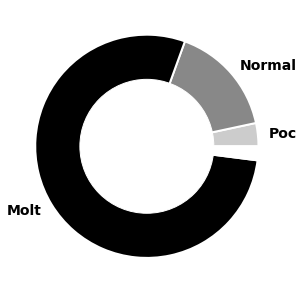

r1    0.033557
r2    0.161074
r3    0.785235
      0.020134
Name: frame_pr3, dtype: float64

In [123]:
pr3_counts = df_participants_frame['frame_pr3'].value_counts(normalize=True)[['r1', 'r2', 'r3','']]
pr3_counts=pr3_counts.fillna(0)

labels = ['Poc', 'Normal', 'Molt', '']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

tricolors_none = ['#CCCCCC', '#888888', 'black', '#FFFFFF']

patches, texts = plt.pie(pr3_counts, labels=labels, 
        colors=tricolors_none, 
        wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio fiscal per ajuts', **title_font)
plt.savefig('figures/Olesa/03_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

pr3_counts

**pr4:** Quin creus que és el preu mig del lloguer d’una casa de 70m2 en bones condicions a {municipi}?

count    145.000000
mean     553.793103
std      116.082280
min      300.000000
25%      500.000000
50%      600.000000
75%      600.000000
max      800.000000
Name: frame_pr4, dtype: float64

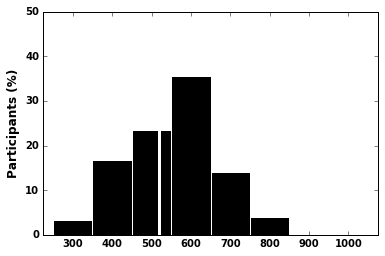

In [124]:
df_participants_frame['frame_pr4']

plt.clf()
plt_rent = df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
plt_rent.set_xticklabels(['300', '400', '500', '600', '700', '800', '900', '1000'])

max_y = 0.5
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], ['0',10,20,30,40,50], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
#plt.title('Regim de tinenca de la teva llar', **title_font)
plt.vlines(2.2, 0, 1000, colors=colors[1], linewidth=3)
plt.ylim(0,max_y)
plt.savefig('figures/Olesa/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']]

mapping_pr4 = {'r1': 300, 'r2': 400, 'r3': 500, 'r4': 600, 'r5': 700, 'r6': 800, 'r7': 900, 'r8': 1000, '': None}
df_participants_frame_numeric = df_participants_frame.replace({'frame_pr4': mapping_pr4})
df_participants_frame_numeric['frame_pr4'].describe()


### Despeses Habitatge

**pr5:** Quin percentatge dels teus ingressos mensuals nets dediques a despeses associades a l’accés a l’habitatge?
**pr6:** Quin percentatge dels teus ingressos mensuals nets consideres just dedicar a despeses associades a l’accés a l’habitatge?

||frame_pr5|frame_pr6|
|---------------------|
|r1|<25%|<25%|
|r2|25-34%|25-34%|
|r3|35-44%|35-44%|
|r4|45-54%|45-54%|
|r5|55-64%|55-64%|
|r6|65-74%|65-74%|
|r7|>74%|>74%|


#### Tots el participants


count    145.000000
mean      25.793103
std       12.115988
min       12.000000
25%       12.000000
50%       29.500000
75%       29.500000
max       69.500000
Name: frame_pr6, dtype: float64

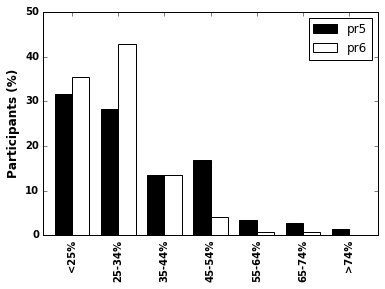

In [125]:
pr5_counts = df_participants_frame['frame_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
pr6_counts = df_participants_frame['frame_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
df_expenses = pd.DataFrame({'pr5': pr5_counts, 'pr6': pr6_counts}, index=index)

plt_expenses = df_expenses.plot(kind='bar', rot=90, width=0.75, color=colors, edgecolor = "black")
#plt_expenses = df_expenses['pr5'].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")
#plt_expenses = df_expenses['pr6'].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")

mapping_pr56 = {'r1': float(0+24)/2, 'r2': float(25+34)/2, 'r3': float(35+44)/2, 'r4': float(45+54)/2, 'r5': float(55+64)/2, 'r6': float(65+74)/2, 'r7': float(75+100)/2, '': None}
df_participants_frame_numeric = df_participants_frame.replace({'frame_pr5': mapping_pr56, 'frame_pr6': mapping_pr56})

#plt.vlines(, 0, 1000, colors=colors[1], linewidth=3)


max_y = 0.5
# plt_expenses.get_legend().remove()
plt_expenses.set_xticklabels(['<25%', '25-34%', '35-44%', '45-54%', '55-64%', '65-74%', '>74%'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], ['0',10,20,30,40,50], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.title('', **title_font)
plt.ylim(0,max_y)
#plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

plt.savefig('figures/Olesa/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
#plt.savefig('figures/Olesa/05_despeses_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
#plt.savefig('figures/Olesa/06_despeses_justes_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#df_participants_frame_numeric['frame_pr5'].describe()
df_participants_frame_numeric['frame_pr6'].describe()





#### Participants que són llogueters


En regim de lloguer a preu de mercat


,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6,socio_pr1,socio_pr2,socio_pr3,socio_pr4,socio_pr5,socio_pr6,socio_pr7
count,15,15,15,15,15,15,15,15,15,15,15,15,15
unique,3,3,2,4,6,4,3,5,2,3,4,1,2
top,r3,r3,r3,r4,r4,r3,W,r5,08640,r5,r2,r3,r2
freq,9,11,13,7,6,6,9,6,14,9,6,15,13


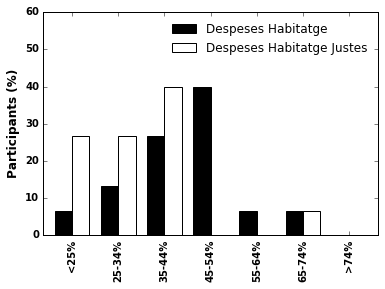

In [126]:
df_participants_socio_frame = pd.concat([df_participants_frame,df_participants_socio], axis=1, join='inner')

#print 'En regim de lloguer a qualsevol preu'
#df_participants_llogaters = df_participants_socio_frame[(df_participants_socio_frame['socio_pr6']=='r3') | (df_participants_socio_frame['socio_pr6']=='r4')]

print 'En regim de lloguer a preu de mercat'
df_participants_llogaters = df_participants_socio_frame[(df_participants_socio_frame['socio_pr6']=='r3')]

pr5_counts_llogaters = df_participants_llogaters['frame_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
pr6_counts_llogaters = df_participants_llogaters['frame_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]

index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
df_expenses = pd.DataFrame({'pr5': pr5_counts_llogaters, 'pr6': pr6_counts_llogaters}, index=index)

plt_expenses = df_expenses.plot(kind='bar', rot=90, width=0.75, color=colors, edgecolor = "black")

max_y = 0.60
# plt_expenses.get_legend().remove()
plt_expenses.set_xticklabels(['<25%', '25-34%', '35-44%', '45-54%', '55-64%', '65-74%', '>74%'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6], ['0',10,20,30,40,50,60], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.title('', **title_font)
plt.ylim(0,max_y)
plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

plt.savefig('figures/Olesa/05_llogaters_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#pr5_counts_llogaters
#pr6_counts_llogaters
df_participants_llogaters.describe()

### Preguntes finals

In [10]:
text_dataset = 'final_FP' 
df_participants_final = pd.DataFrame(list(df_participants_OM['final']))

#'final_pr5': u[33], # q: Coneixes iniciatives d’habitatge cooperatiu?
#'final_pr6': u[34], # q: En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
    
    

**pr1:** En quina mesura creus que ha d’haver-hi un control públic de l’habitatge? **pr2:** En quina mesura estàs d’acord amb la necessitat de tenir un sistema que garanteixi la consideració de l’habitatge com un bé de primera necessitat? **pr3:** En quina mesura creus que la presència de pisos buits afecta la situació de l'habitatge al municipi? **pr4:** En quina mesura estàs d’acord amb la necessitat de prioritzar el dret a l’habitatge per a col·lectius vulnerables? 



,final_pr1,final_pr2,final_pr3,final_pr4,final_pr6
count,149.000000,149.000000,149.000000,149.000000,134.000000
mean,6.013423,6.476510,6.208054,6.060403,5.455224
std,1.325359,1.094111,1.326829,1.356806,1.368912
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,6.000000,6.000000,5.000000,5.000000
50%,7.000000,7.000000,7.000000,7.000000,5.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000


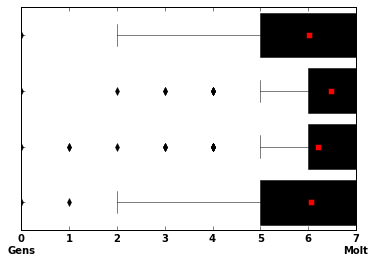

In [11]:
plt.clf()
mapping = {'r1': 0, 'r2': 1, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 5, 'r7': 6, 'r8': 7, 'rx': None}
df_participants_final_numeric = df_participants_final.replace({'final_pr1': mapping, 'final_pr2': mapping, 'final_pr3': mapping, 'final_pr4': mapping, 'final_pr6': mapping})
ax = sns.boxplot(data=df_participants_final_numeric[['final_pr1','final_pr2','final_pr3','final_pr4']], 
            orient = 'h', linewidth=0.5, showmeans=True, color=colors[0])

ax.set_xticklabels(['0\nGens', '1', '2', '3', '4', '5', '6', '7\nMolt'], **ticks_font)
#ax.set_yticklabels(['Q1', 'Q2', 'Q3', 'Q4'], **ticks_font)
ax.set_yticklabels(['', '', '', ''], **ticks_font)
plt.savefig('figures/Olesa/01_04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#df_participants_final_numeric['final_pr1'].describe()
#df_participants_final_numeric['final_pr2'].describe()
#df_participants_final_numeric['final_pr3'].describe()
#df_participants_final_numeric['final_pr4'].describe()
df_participants_final_numeric.describe()




**pr5** Coneixes iniciatives d’habitatge cooperatiu? **pr6** En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
    

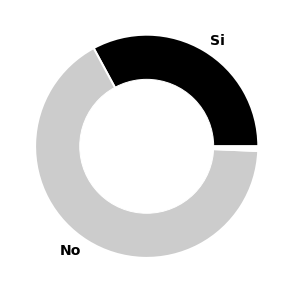

r1    0.328859
r2    0.664430
r3    0.006711
           NaN
Name: final_pr5, dtype: float64

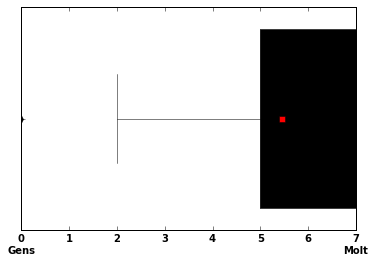

In [13]:
plt.clf()

freq_cooperative = df_participants_final['final_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', '']]

labels = ['Si', 'No', '', '']

quatricolors_none = ['black', '#CCCCCC', '#FFFFFF', '#FFFFFF']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie(freq_cooperative, labels=labels, colors=quatricolors_none,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

[ _.set_fontsize(14) for _ in texts ]
[ _.set_fontweight('bold') for _ in texts ]


p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/Olesa/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots()

bplot = sns.boxplot(data=df_participants_final_numeric[['final_pr6']], orient = 'h', linewidth=0.5, showmeans=True, color=colors[0])
bplot.set_xticklabels(['0\nGens', '1', '2', '3', '4', '5', '6', '7\nMolt'], **ticks_font)
bplot.set_yticklabels([''], **ticks_font)

for p, artist in enumerate(ax.artists):
    for q in range(p*6, p*6+6):
        line = ax.lines[6]
        line.set_color('white')


plt.savefig('figures/Olesa/06_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_final_numeric[['final_pr6']].describe()
                              
freq_cooperative

In [130]:
print 'Participants que coneixen cooperatives'

cooperativa_si = df_participants_final_numeric[(df_participants_final['final_pr5']=='r1')]
cooperativa_si['final_pr6'].describe()


Participants que coneixen cooperatives


count    49.000000
mean      5.612245
std       1.366509
min       2.000000
25%       5.000000
50%       6.000000
75%       7.000000
max       7.000000
Name: final_pr6, dtype: float64

In [131]:
print 'Participants que no coneixen cooperatives'

cooperativa_no = df_participants_final_numeric[(df_participants_final['final_pr5']=='r2')]
cooperativa_no['final_pr6'].describe()



Participants que no coneixen cooperatives


count    84.000000
mean      5.369048
std       1.377791
min       0.000000
25%       4.750000
50%       5.000000
75%       7.000000
max       7.000000
Name: final_pr6, dtype: float64

### Preu dels lloguer

In [132]:
text_dataset = 'economy_OM' 
df_participants_economy = df_participants_OM[['id', 'intervention', 'house', 'house_price', 'round_rented', 'endowment_final']].copy()
df_participants_economy['decication'] = df_participants_economy['house_price']/rent_OM
#df_participants_economy





#### Preu mitja que els participants han pagat pel lloguer

In [133]:
df_participants_economy[df_participants_economy['house'] == 1]['house_price'].describe()


count    144.000000
mean     576.855723
std       39.884749
min      483.835008
25%      562.910536
50%      570.000000
75%      598.500000
max      692.838562
Name: house_price, dtype: float64

#### Preu mitja que els participants han pagat pel lloguer segons tractament

In [134]:
print 'NONE'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'NONE')]['house_price'].describe()


NONE


count     70.000000
mean     583.035859
std       38.972463
min      483.835008
25%      564.674924
50%      570.000000
75%      598.500000
max      692.838562
Name: house_price, dtype: float64

In [135]:
print 'BOTH'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'BOTH')]['house_price'].describe()



BOTH


count     74.000000
mean     571.009649
std       40.116257
min      485.047627
25%      537.785642
50%      570.000000
75%      598.500000
max      628.425000
Name: house_price, dtype: float64

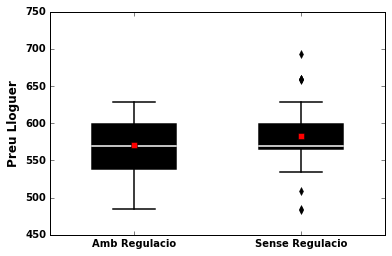

In [136]:
fig, ax = plt.subplots()

# bplot=sns.stripplot(x='intervention', # vertical
#                    y='house_price',
#                    orient = 'v',
#                    data=df_participants_economy, 
#                    jitter=True, 
#                    marker='o', 
#                    palette=bicolors_black, 
#                    edgecolor=bicolors_black, 
#                    facecolors="none")


bplot =sns.boxplot(x='intervention', # vertical
                  y='house_price',
                  orient = 'v', 
                  data=df_participants_economy, 
                  width=.5, 
                  #palette=bicolors_grey, 
                  linewidth=1.5,
                  showmeans=True,
                  color=colors[0])


for p, artist in enumerate(ax.artists):
    for q in range(p*6, p*6+6):
        line = ax.lines[4]
        line.set_color('white')
        line = ax.lines[11]
        line.set_color('white')

    

min_y = 450
max_y = 750
plt.xticks([0,1], ['Amb Regulacio', 'Sense Regulacio'],**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.ylim(min_y, max_y)

plt.savefig('figures/Olesa/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)



#### Dedicacio a les despeses de habitatge

Mitjana despeses habitatge


count    144.000000
mean       0.351099
std        0.024276
min        0.294483
25%        0.342611
50%        0.346926
75%        0.364273
max        0.421691
Name: decication, dtype: float64

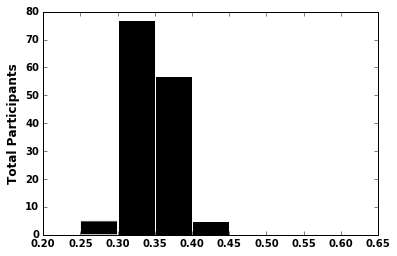

In [137]:
print 'Mitjana despeses habitatge'
df_participants_economy['decication'].describe()

fig, ax = plt.subplots()
df_participants_economy['decication'].hist(bins=[0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65], color=colors[0], edgecolor = "white")
min_y = 0
max_y = 50

plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Total Participants', **axis_font)
plt.grid(False)

plt.savefig('figures/Olesa/01_dedication_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#plt.title('', **title_font)
#plt.ylim(min_y, max_y)

df_participants_economy['decication'].describe()


### Evolució del mercat

#### Mesos que tarden en llogar un habitatge

In [138]:
text_treatment = 'ALL'
df_participants_economy[(df_participants_economy['house'] == 1)]['round_rented'].describe()


count    143.000000
mean       5.146853
std        3.564216
min        1.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       12.000000
Name: round_rented, dtype: float64

In [139]:
text_treatment = 'NONE'
print 'NONE'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'NONE')]['round_rented'].describe()


NONE


count    69.000000
mean      5.173913
std       3.613522
min       1.000000
25%       2.000000
50%       4.000000
75%       8.000000
max      12.000000
Name: round_rented, dtype: float64

In [140]:
text_treatment = 'BOTH'
print 'BOTH'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'BOTH')]['round_rented'].describe()



BOTH


count    74.000000
mean      5.121622
std       3.542125
min       1.000000
25%       2.000000
50%       4.000000
75%       7.750000
max      12.000000
Name: round_rented, dtype: float64

#### Impacte de les polítiques de habitatge

In [141]:
df_games = pd.DataFrame(games)

df_games_valid = df_games[(df_games['status'] != 'TEST')]
df_games_valid

df_games_no_treatment = df_games[(df_games['control_intervention'] == 'NONE') & (df_games['status'] != 'TEST')]
df_games_no_treatment

df_games = pd.DataFrame(games)
df_games_treatment = df_games[(df_games['control_intervention'] == 'BOTH') & (df_games['status'] != 'TEST')]
df_games_treatment


increments_valid = []
increments_no_treatment = []
increments_treatment = []

price_valid = []
price_no_treatment = []
price_treatment = []

for round_ in df_games_valid['rounds']:
    for r in round_:
        increments_valid.append(r['increment'])
        price_valid.append(r['price_init'])
        
df_games_valid_limits = pd.DataFrame()
df_games_valid_limits['increment'] = increments_valid
df_games_valid_limits['price'] = price_valid
df_games_valid_limits['increment'].value_counts(normalize=True)

for round_ in df_games_no_treatment['rounds']:
    for r in round_:
        increments_no_treatment.append(r['increment'])
        price_no_treatment.append(r['price_init'])
        
df_games_no_treatment_limits = pd.DataFrame()
df_games_no_treatment_limits['increment'] = increments_no_treatment
df_games_no_treatment_limits['price'] = price_no_treatment
df_games_no_treatment_limits['increment'].value_counts(normalize=True)

for round_ in df_games_treatment['rounds']:
    for r in round_:
        increments_treatment.append(r['increment'])
        price_treatment.append(r['price_init'])
        
df_games_treatment_limits = pd.DataFrame()
df_games_treatment_limits['increment'] = increments_treatment
df_games_treatment_limits['price'] = price_treatment


high_limit_OM
low_limit_OM

df_games_treatment_limits['increment'].value_counts(normalize=True)
#df_games_no_treatment_limits['increment'].value_counts(normalize=True)


## No limits
above_no_limit = len(df_games_no_treatment_limits[(df_games_no_treatment_limits['price']>high_limit_OM)])/float(len(df_games_no_treatment_limits))
under_no_limit = len(df_games_no_treatment_limits[(df_games_no_treatment_limits['price']<low_limit_OM)])/float(len(df_games_no_treatment_limits))
between_no_limit = len(df_games_no_treatment_limits[(df_games_no_treatment_limits['price']>low_limit_OM) & (df_games_no_treatment_limits['price']<high_limit_OM)])/float(len(df_games_no_treatment_limits))

counts_no_treatment_limits = [under_no_limit, between_no_limit, above_no_limit]

above_limit = len(df_games_treatment_limits[(df_games_treatment_limits['price']*1.05>high_limit_OM)])/float(len(df_games_treatment_limits))
under_limit = len(df_games_treatment_limits[(df_games_treatment_limits['price']*0.95<low_limit_OM)])/float(len(df_games_treatment_limits))
between_limit = len(df_games_treatment_limits[(df_games_treatment_limits['price']*0.95>low_limit_OM) & (df_games_treatment_limits['price']*1.05<high_limit_OM)])/float(len(df_games_treatment_limits))

counts_treatment_limits = [under_limit, between_limits, above_limit]

df_counts_limits = pd.DataFrame()
df_counts_limits['no_treatment'] = counts_no_treatment_limits
df_counts_limits['treatment'] = counts_treatment_limits

#index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
#df_expenses = pd.DataFrame({'pr5': pr5_counts_llogaters, 'pr6': pr6_counts_llogaters}, index=index)

plt_limits = df_counts_limits.plot(kind='bar', rot=0, width=0.75, color=colors, edgecolor = "black")

#max_y = 0.60
# plt_expenses.get_legend().remove()
plt_limits.set_xticklabels(['< limit inferior', '', '> limit superior'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
#plt.xticks(**ticks_font)
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6], ['0',10,20,30,40,50,60], **ticks_font)
#plt.xlabel('', **axis_font)
#plt.ylabel('Participants (%)', **axis_font)
#plt.title('', **title_font)
#plt.ylim(0,max_y)
#plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

#plt.savefig('figures/Olesa/05_llogaters_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
df_counts_limits


# primera vegada que es toca el limit
# dispersio a un pas (probabilitat de pujar)

NameError: name 'between_limits' is not defined

#### Preus acceptats i no acceptats

In [142]:
num_round = []
selections = []
prices = []
intervention = []
increments = []

for index, d in enumerate(df_participants_OM['rounds']):
    for r in d:
        if r['is_selected'] == 1:
            increments.append(r['increment'])
            num_round.append(r['num_round'])
            selections.append(r['selection'])
            prices.append(r['price'])
            intervention.append(df_participants_OM.iloc[index]['intervention'])
            
df_prices = pd.DataFrame({'num_round': num_round, 'selections': selections, 'prices': prices, 'intervention': intervention, 'increments': increments})


#### Acceptació del preu de entrada



In [143]:
acceptacio = df_prices[df_prices['num_round']==1]['selections'].value_counts(normalize=True)
print 'El %.2f no va aceptar el preu proposat' %(acceptacio[0]*100)
print 'El %.2f va aceptar el preu proposat' %(acceptacio[1]*100)


El 54.42 no va aceptar el preu proposat
El 45.58 va aceptar el preu proposat


#### Preu mitjà que els participants han estat disposats a pagar pel lloguer


In [144]:
print 'Preus acceptats'
df_prices[(df_prices['selections'] == 1)]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()


Preus acceptats


count    223.000000
mean     579.180002
std       36.263217
min      483.835008
25%      567.153563
50%      570.000000
75%      598.500000
max      692.838562
Name: prices, dtype: float64

In [145]:
print 'Preus acceptats tractament sense intervencio'
df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'NONE')]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()

Preus acceptats tractament sense intervencio


count    116.000000
mean     583.562947
std       35.619053
min      483.835008
25%      569.643750
50%      570.000000
75%      598.500000
max      692.838562
Name: prices, dtype: float64

In [146]:
print 'Preus acceptats tractament amb intervencio'
df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'BOTH')]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()

Preus acceptats tractament amb intervencio


count    107.000000
mean     574.428398
std       36.521897
min      485.047627
25%      567.153563
50%      570.000000
75%      598.500000
max      628.425000
Name: prices, dtype: float64

In [147]:
print 'Preus no acceptats'
df_prices[(df_prices['selections'] == 0)]['prices'].describe()
#df_prices[(df_prices['selections'] == 0)]['prices'].hist()


Preus no acceptats


count    581.000000
mean     586.838808
std       37.868655
min      485.047627
25%      567.153563
50%      595.511241
75%      598.500000
max      727.480491
Name: prices, dtype: float64

#### Histograma de tots els preus acceptats

,price,1,0,perc_1,perc_0
0,485.0,7.0,7.0,0.500000,0.500000
1,510.0,9.0,30.0,0.230769,0.769231
2,537.0,20.0,47.0,0.298507,0.701493
3,566.0,93.0,179.0,0.341912,0.658088
4,595.0,58.0,182.0,0.241667,0.758333
5,626.0,29.0,107.0,0.213235,0.786765
6,658.0,6.0,20.0,0.230769,0.769231
7,692.0,1.0,8.0,0.111111,0.888889
8,727.0,0.0,1.0,0.000000,1.000000


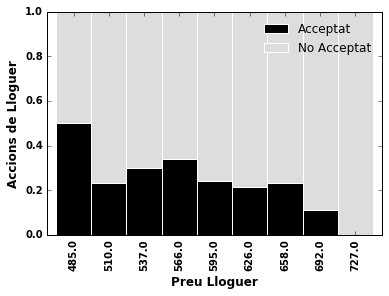

In [148]:
## Binned All Games

df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1)]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0)]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:3])), 
           np.round(np.mean(df_prices_count['price'].iloc[3:7])), 
           np.round(np.mean(df_prices_count['price'].iloc[7:14])), 
           np.round(np.mean(df_prices_count['price'].iloc[14:22])), 
           np.round(np.mean(df_prices_count['price'].iloc[22:30])), 
           np.round(np.mean(df_prices_count['price'].iloc[30:35])), 
           np.round(np.mean(df_prices_count['price'].iloc[35:38])), 
           np.round(np.mean(df_prices_count['price'].iloc[38:40])), 
           np.round(np.mean(df_prices_count['price'].iloc[40]))]

ones_ = [np.round(np.sum(df_prices_count['1'].iloc[0:3])), 
         np.round(np.sum(df_prices_count['1'].iloc[3:7])), 
         np.round(np.sum(df_prices_count['1'].iloc[7:14])), 
         np.round(np.sum(df_prices_count['1'].iloc[14:22])), 
         np.round(np.sum(df_prices_count['1'].iloc[22:30])), 
         np.round(np.sum(df_prices_count['1'].iloc[30:35])), 
         np.round(np.sum(df_prices_count['1'].iloc[35:38])), 
         np.round(np.sum(df_prices_count['1'].iloc[38:40])), 
         np.round(np.sum(df_prices_count['1'].iloc[40]))]

zeros_ = [np.round(np.sum(df_prices_count['0'].iloc[0:3])), 
         np.round(np.sum(df_prices_count['0'].iloc[3:7])), 
         np.round(np.sum(df_prices_count['0'].iloc[7:14])), 
         np.round(np.sum(df_prices_count['0'].iloc[14:22])), 
         np.round(np.sum(df_prices_count['0'].iloc[22:30])), 
         np.round(np.sum(df_prices_count['0'].iloc[30:35])), 
         np.round(np.sum(df_prices_count['0'].iloc[35:38])), 
         np.round(np.sum(df_prices_count['0'].iloc[38:40])), 
         np.round(np.sum(df_prices_count['0'].iloc[40]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/Olesa/02_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned



#### Histograma dels preus acceptats amb intervencio

Both


,price,1,0,perc_1,perc_0
0,486.0,4.0,7.0,0.363636,0.636364
1,510.0,8.0,26.0,0.235294,0.764706
2,537.0,11.0,35.0,0.239130,0.760870
3,566.0,41.0,101.0,0.288732,0.711268
4,595.0,27.0,92.0,0.226891,0.773109
5,626.0,16.0,58.0,0.216216,0.783784


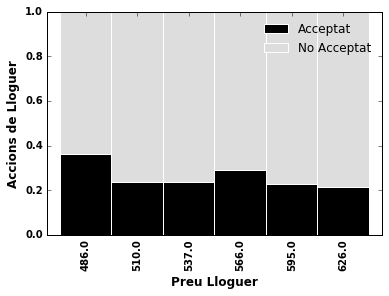

In [149]:
## Binned Both Games

print 'Both'
df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'BOTH')]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0) & (df_prices['intervention'] == 'BOTH')]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:2])), 
           np.round(np.mean(df_prices_count['price'].iloc[2:6])), 
           np.round(np.mean(df_prices_count['price'].iloc[6:12])), 
           np.round(np.mean(df_prices_count['price'].iloc[12:20])), 
           np.round(np.mean(df_prices_count['price'].iloc[20:26])), 
           np.round(np.mean(df_prices_count['price'].iloc[26:30]))]

ones_ = [np.round(np.sum(df_prices_count['1'].iloc[0:2])), 
         np.round(np.sum(df_prices_count['1'].iloc[2:6])), 
         np.round(np.sum(df_prices_count['1'].iloc[6:12])), 
         np.round(np.sum(df_prices_count['1'].iloc[12:20])), 
         np.round(np.sum(df_prices_count['1'].iloc[20:26])), 
         np.round(np.sum(df_prices_count['1'].iloc[26:30]))]

zeros_ = [np.round(np.sum(df_prices_count['0'].iloc[0:2])), 
         np.round(np.sum(df_prices_count['0'].iloc[2:6])), 
         np.round(np.sum(df_prices_count['0'].iloc[6:12])), 
         np.round(np.sum(df_prices_count['0'].iloc[12:20])), 
         np.round(np.sum(df_prices_count['0'].iloc[20:26])), 
         np.round(np.sum(df_prices_count['0'].iloc[26:30]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/Olesa/02_both_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned



#### Histograma dels preus acceptats sense intervencio (Revisar)

None


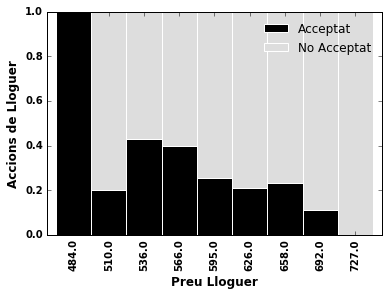

In [150]:
## Binned None Games


print 'None'
df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'NONE')]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0) & (df_prices['intervention'] == 'NONE')]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:2])), 
           np.round(np.mean(df_prices_count['price'].iloc[2:4])), 
           np.round(np.mean(df_prices_count['price'].iloc[4:10])), 
           np.round(np.mean(df_prices_count['price'].iloc[10:18])), 
           np.round(np.mean(df_prices_count['price'].iloc[18:26])), 
           np.round(np.mean(df_prices_count['price'].iloc[26:31])), 
           np.round(np.mean(df_prices_count['price'].iloc[31:34])), 
           np.round(np.mean(df_prices_count['price'].iloc[34:36])), 
           np.round(np.mean(df_prices_count['price'].iloc[36]))]

ones_ = [np.round(np.sum(df_prices_count['1'].iloc[0:2])), 
         np.round(np.sum(df_prices_count['1'].iloc[2:4])), 
         np.round(np.sum(df_prices_count['1'].iloc[4:10])), 
         np.round(np.sum(df_prices_count['1'].iloc[10:18])), 
         np.round(np.sum(df_prices_count['1'].iloc[18:26])), 
         np.round(np.sum(df_prices_count['1'].iloc[26:31])), 
         np.round(np.sum(df_prices_count['1'].iloc[31:34])), 
         np.round(np.sum(df_prices_count['1'].iloc[34:36])), 
         np.round(np.sum(df_prices_count['1'].iloc[36]))]

zeros_ = [np.round(np.sum(df_prices_count['0'].iloc[0:2])), 
         np.round(np.sum(df_prices_count['0'].iloc[2:4])), 
         np.round(np.sum(df_prices_count['0'].iloc[4:10])), 
         np.round(np.sum(df_prices_count['0'].iloc[10:18])), 
         np.round(np.sum(df_prices_count['0'].iloc[18:26])), 
         np.round(np.sum(df_prices_count['0'].iloc[26:31])), 
         np.round(np.sum(df_prices_count['0'].iloc[31:34])), 
         np.round(np.sum(df_prices_count['0'].iloc[34:36])), 
         np.round(np.sum(df_prices_count['0'].iloc[36]))]



df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/Olesa/02_none_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)


### Evolucio del preu del lloger

,0,1,2,3,4,5,6,7,8,9,10,11
0,570.0,598.5,568.575,597.00375,567.153563,538.795884,511.856090,537.448895,510.576450,536.105272,509.300009,NaN
1,570.0,598.5,628.425,628.42500,597.003750,567.153563,595.511241,565.735679,537.448895,510.576450,536.105272,NaN
2,570.0,598.5,628.425,597.00375,626.853938,626.853938,595.511241,625.286803,594.022463,564.321339,536.105272,509.300009
3,570.0,598.5,568.575,540.14625,567.153563,595.511241,565.735679,537.448895,510.576450,485.047627,509.300009,509.300009
4,570.0,598.5,628.425,597.00375,567.153563,595.511241,565.735679,594.022463,564.321339,536.105272,509.300009,509.300009
5,570.0,598.5,628.425,628.42500,628.425000,597.003750,567.153563,595.511241,565.735679,537.448895,NaN,NaN
6,570.0,598.5,568.575,597.00375,567.153563,538.795884,511.856090,537.448895,564.321339,536.105272,562.910536,534.765009
7,570.0,598.5,628.425,628.42500,597.003750,567.153563,538.795884,511.856090,486.263286,510.576450,536.105272,NaN
8,570.0,598.5,628.425,628.42500,628.425000,628.425000,NaN,NaN,NaN,NaN,NaN,NaN
9,570.0,598.5,628.425,597.00375,626.853938,595.511241,625.286803,594.022463,623.723586,592.537406,562.910536,NaN


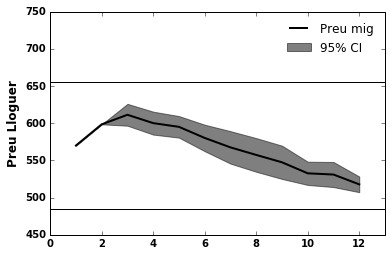

In [151]:
df_games = pd.DataFrame(games)
df_games_treatment = df_games[(df_games['control_intervention'] == 'BOTH') & (df_games['status'] != 'TEST')]

prices_rounds = []

for i, row in df_games_treatment.iterrows():
    rounds = [r['num_round'] for r in df_games_treatment['rounds'][i]]
    price = [r['price_init'] for r in df_games_treatment['rounds'][i]]
    prices_rounds.append(np.array(price))

    
df_prices_rounds = pd.DataFrame(data=prices_rounds)
df_prices_rounds

price_average = df_prices_rounds.loc[:,:].mean()
price_std = df_prices_rounds.loc[:,:].std()
price_sem = df_prices_rounds.loc[:,:].sem()

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

plt.figure()
error_lower = [price_average[i] -  1.96*(price_sem[i]) for i, e in enumerate(price_average)]
error_higher = [price_average[i] +  1.96*(price_sem[i]) for i, e in enumerate(price_average)]

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(range(1,len(price_average)+1,1), error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(range(1,len(price_average)+1,1), price_average, color="black", zorder=4, label='Preu mig', linewidth=2)

plt.ylim(450,750)
plt.hlines(655, 0, 13, colors='black', linewidth=1, linestyles='solid', label='')
plt.hlines(485, 0, 13, colors='black', linewidth=1, linestyles='solid', label='')
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(fancybox=True, framealpha=0)
ax = plt.axes()

plt.savefig('figures/Olesa/03_treatment_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)


df_prices_rounds


,0,1,2,3,4,5,6,7,8,9,10,11
0,570.0,598.5,628.425,597.00375,626.853938,595.511241,625.286803,594.022463,564.321339,536.105272,562.910536,534.765009
1,570.0,598.5,628.425,659.84625,692.838562,727.480491,691.106466,656.551143,623.723586,592.537406,562.910536,534.765009
2,570.0,598.5,628.425,597.00375,567.153563,595.511241,565.735679,537.448895,510.576450,485.047627,509.300009,483.835008
3,570.0,598.5,628.425,659.84625,626.853938,595.511241,625.286803,594.022463,623.723586,592.537406,562.910536,NaN
4,570.0,598.5,628.425,597.00375,626.853938,595.511241,565.735679,594.022463,564.321339,592.537406,562.910536,NaN
5,570.0,598.5,628.425,659.84625,692.838562,658.196634,691.106466,656.551143,623.723586,592.537406,562.910536,534.765009
6,570.0,598.5,628.425,659.84625,626.853938,595.511241,625.286803,594.022463,564.321339,592.537406,562.910536,NaN
7,570.0,598.5,628.425,659.84625,626.853938,595.511241,625.286803,594.022463,564.321339,536.105272,562.910536,NaN
8,570.0,598.5,628.425,659.84625,626.853938,658.196634,691.106466,656.551143,623.723586,592.537406,562.910536,534.765009
9,570.0,598.5,628.425,659.84625,692.838562,658.196634,625.286803,594.022463,623.723586,592.537406,562.910536,NaN


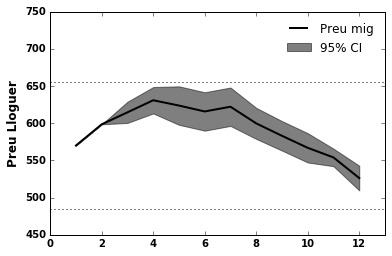

In [152]:
df_games = pd.DataFrame(games)
df_games_no_treatment = df_games[(df_games['control_intervention'] == 'NONE') & (df_games['status'] != 'TEST')]

prices_rounds = []

for i, row in df_games_no_treatment.iterrows():
    rounds = [r['num_round'] for r in df_games_no_treatment['rounds'][i]]
    price = [r['price_init'] for r in df_games_no_treatment['rounds'][i]]
    prices_rounds.append(np.array(price))

    
df_prices_rounds = pd.DataFrame(data=prices_rounds)

price_average = df_prices_rounds.loc[:,:].mean()
price_std = df_prices_rounds.loc[:,:].std()
price_sem = df_prices_rounds.loc[:,:].sem()

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

plt.figure()
error_lower = [price_average[i] -  1.96*(price_sem[i]) for i, e in enumerate(price_average)]
error_higher = [price_average[i] +  1.96*(price_sem[i]) for i, e in enumerate(price_average)]

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(range(1,len(price_average)+1,1), error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(range(1,len(price_average)+1,1), price_average, color="black", zorder=4, label='Preu mig', linewidth=2)

plt.ylim(450,750)
plt.hlines(655, 0, 13, colors='black', linewidth=1, linestyles='dotted', label='')
plt.hlines(485, 0, 13, colors='black', linewidth=1, linestyles='dotted', label='')
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(fancybox=True, framealpha=0)
ax = plt.axes()

plt.savefig('figures/Olesa/03_no_treatment_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_rounds



### Estalvis en funcio del mes que es lloga

[ 717.65033923 1035.03734051  744.65783441  533.92627567  284.75878004
  599.82450465  606.91278957  998.66929501 1032.31314795 1057.17278316
 1049.26217349 1070.39219294]
12


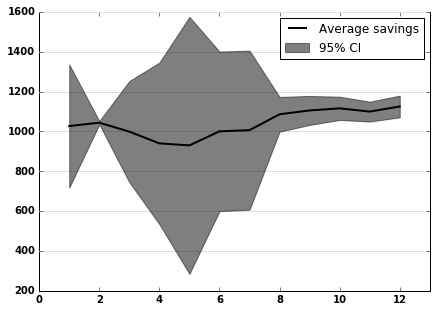

In [153]:
df_round_savings = df_participants_economy[df_participants_economy['house'] == 1][['round_rented','endowment_final']]

#df_round_savings.groupby('round_rented').count()

savings_average = df_round_savings.groupby('round_rented').mean()
savings_std = df_round_savings.groupby('round_rented').std()
savings_sem = df_round_savings.groupby('round_rented').sem()



savings = pd.concat([df_round_savings.groupby('round_rented').count(),
                     savings_average.fillna(0), 
                     savings_sem.fillna(0), 
                     savings_std.fillna(0)], 
                     axis=1, join='inner')
savings.columns = ['n', 'mean', 'std', 'sem']

savings['error_higher'] = savings['mean'] + 1.96*savings['sem']
savings['error_lower'] = savings['mean'] - 1.96*savings['sem']

rounds = savings.index.values
average = savings.iloc[:,1].values
error_lower = savings.iloc[:,5].values
error_higher = savings.iloc[:,4].values

print error_lower
print len(error_lower)

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

fig = plt.figure(figsize=(7,5))

#error_lower = 
#error_higher = 

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(rounds, error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(rounds, average, color="black", zorder=4, label='Average savings', linewidth=2)

plt.ylim()
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.title('', **title_font)
plt.legend()
ax = plt.axes()
ax.yaxis.grid(color='#DDDDDD', linestyle='-', linewidth=1)

plt.savefig('figures/Olesa/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300)


In [154]:
savings

,n,mean,std,sem,error_higher,error_lower
round_rented,,,,,,
1.0,25,1026.624800,31.528006,157.640031,1335.599261,717.650339
2.0,20,1043.531000,0.969000,4.333500,1052.024659,1035.037341
3.0,17,998.732353,31.439858,129.629856,1252.806871,744.657834
4.0,12,939.762500,59.772871,207.059298,1345.598724,533.926276
5.0,10,929.718038,104.058176,329.060846,1574.677295,284.758780
6.0,13,1000.181650,56.652599,204.263850,1400.538796,599.824505
7.0,8,1006.055796,71.999165,203.644391,1405.198802,606.912790
8.0,6,1085.795256,18.147462,44.452021,1172.921217,998.669295
9.0,5,1105.039249,16.593929,37.105154,1177.765351,1032.313148


#### Socio + Polítiques Públiques

In [155]:
df_socio_frame = pd.concat([df_participants_socio, df_participants_frame], axis=1, join='inner')
df_socio_frame.tail()

,socio_pr1,socio_pr2,socio_pr3,socio_pr4,socio_pr5,socio_pr6,socio_pr7,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6
144,W,r8,08640,r3,r2,r1,r1,r1,r3,r3,r2,r4,r3
145,M,r8,08640,r5,r2,r1,r1,r1,r2,r2,r4,r1,r1
146,W,r6,08640,r3,r2,r1,r2,r2,r3,r3,r2,r2,r1
147,NB,r4,08640,r3,r3,r8,r2,r2,r3,r3,r4,r1,r1
148,W,r4,08640,r4,r2,r1,r1,r3,r3,r3,r3,r1,r3


|  |socio_pr1|
|----------|
|r1| Home | 
|r2| Dona | 
|r3| No binària | 
|r4| No vull contestar |

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|




Correlacio entre genere i la limitacio de renta


socio_pr1,M,W
frame_pr2,,
r1,0.000000,0.028169
r2,0.119718,0.091549
r3,0.366197,0.394366


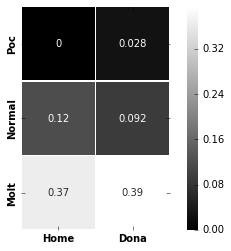

In [156]:
print 'Correlacio entre genere i la limitacio de renta'

df_gender_limit = df_socio_frame[((df_socio_frame['socio_pr1'] == 'M') | (df_socio_frame['socio_pr1'] == 'W')) 
                                 & (df_socio_frame['socio_pr1']!='') & (df_socio_frame['frame_pr2']!='')]

cross = pd.crosstab(df_gender_limit.frame_pr2, df_gender_limit.socio_pr1, normalize=True)

xticks_labels = ['Home', 'Dona']
yticks_labels = ['Poc', 'Normal', 'Molt']

plt.clf()
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels, annot=True)

ax.set_ylabel('')    
ax.set_xlabel('')
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)

cross


|| socio_pr5 |
|------------|
|r1|Sol|
|r2|Llar sense persones a càrrec|
|r3|Llar amb persones a càrrec|
|r4|Més persones que no són parella|

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|

Correlacio entre tipologia de llar i la limitacio de renta


socio_pr5,r1,r2,r3,r4
frame_pr2,,,,
r1,0.006849,0.000000,0.020548,0.000000
r2,0.006849,0.061644,0.082192,0.061644
r3,0.109589,0.246575,0.315068,0.089041


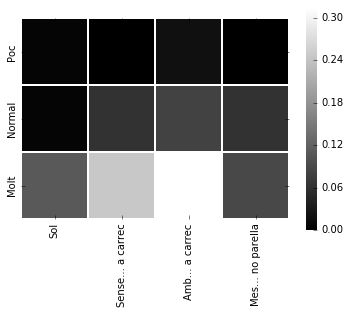

In [157]:
print 'Correlacio entre tipologia de llar i la limitacio de renta'

df_llar_limit = df_socio_frame[(df_socio_frame['socio_pr5']!='') & (df_socio_frame['frame_pr2']!='')]

cross = pd.crosstab(df_llar_limit.frame_pr2,df_llar_limit.socio_pr5, normalize=True)

xticks_labels = ['Sol', 'Sense... a carrec', 'Amb... a carrec', 'Mes... no parella']
yticks_labels = ['Poc', 'Normal', 'Molt']
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels)

ax.set_ylabel('')    
ax.set_xlabel('')

cross



#### Règim de tinença de la teva llar
| |socio_pr6|
|----------|
|r1|En propietat|
|r2|En propietat pendent de pagament (hipoteca)|
|r3|En lloguer o relloguer a preu de mercat|
|r4|En lloguer o relloguer a preu inferior al de mercat|
|r5|En cessió gratuïta|
|r6|Habitació de lloguer|
|r7|Ocupació|
|r8|Altres|

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|

Correlacio entre regim de tinença i la limitacio de renta


socio_pr6,r1,r2,r3,r4,r5,r6,r7,r8
frame_pr2,,,,,,,,
r1,0.013699,0.006849,0.006849,0.000000,0.000000,0.000000,0.000000,0.000000
r2,0.095890,0.054795,0.020548,0.013699,0.000000,0.006849,0.000000,0.020548
r3,0.335616,0.178082,0.075342,0.095890,0.027397,0.013699,0.006849,0.027397


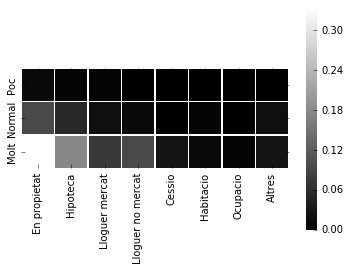

In [158]:
print 'Correlacio entre regim de tinença i la limitacio de renta'

df_regim_limit = df_socio_frame[(df_socio_frame['socio_pr6']!='') & (df_socio_frame['frame_pr2']!='')]

cross = pd.crosstab(df_regim_limit.frame_pr2,df_regim_limit.socio_pr6, normalize=True)

xticks_labels = ['En propietat', 'Hipoteca', 'Lloguer mercat', 'Lloguer no mercat', 'Cessio', 'Habitacio', 'Ocupacio', 'Altres']
yticks_labels = ['Poc', 'Normal', 'Molt']
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels)

ax.set_ylabel('')    
ax.set_xlabel('')

cross





### Frecuencia de preus acceptats en funcio de les ronda a la que acaba el dilema

In [211]:
df_games_OM['final_round'] = np.nan
df_games_OM['final_round_rent'] = np.nan
df_games_OM['final_price_rent'] = np.nan
df_games_OM['total_houses_rented'] = np.nan
df_games_OM['comment'] = np.nan
df_games_OM['limits'] = np.nan

for i, row in df_games_OM.iterrows():
    df_games_OM['final_round'].iloc[i] = len(row['rounds'])
    rent_actions = []
    rent_price = []
    market_price = []
    non_increment = []
    for r in row['rounds']:
        market_price.append(r['price_init'])
        if r['is_rented'] == 1:
            rent_actions.append(r['num_round'])
            rent_price.append(np.round(r['price_init'],2))
            if r['increment'] == 0:
                non_increment.append(r['num_round'])

    df_games_OM['final_price_rent'].iloc[i] = rent_price[len(rent_price)-1]
    df_games_OM['total_houses_rented'].iloc[i] = len(rent_actions)
    df_games_OM['final_round_rent'].iloc[i] = rent_actions[len(rent_actions)-1]
    
    if df_games_OM['control_intervention'].iloc[i] == 'BOTH':
        df_games_OM['limits'].iloc[i] = len(non_increment)

    if len(rent_actions) < 6 and len(row['rounds']) < 12:
        df_games_OM['comment'].iloc[i] = 'INCIDENT'
    
df_games_OM
    

,control_intervention,experiment,id,rounds,status,final_round,final_round_rent,final_price_rent,total_houses_rented,comment,limits
0,BOTH,Olesa,3,"[{u'is_rented': 1, u'user_id': 18, u'price_fin...",FINISHED,11.0,11.0,509.30,5.0,INCIDENT,0.0
1,NONE,Olesa,4,"[{u'is_rented': 1, u'user_id': 23, u'price_fin...",FINISHED,12.0,10.0,536.11,5.0,NaN,NaN
2,BOTH,Olesa,5,"[{u'is_rented': 1, u'user_id': 30, u'price_fin...",FINISHED,11.0,11.0,536.11,6.0,NaN,1.0
3,NONE,Olesa,6,"[{u'is_rented': 1, u'user_id': 34, u'price_fin...",FINISHED,12.0,12.0,534.77,6.0,NaN,NaN
4,BOTH,Olesa,7,"[{u'is_rented': 1, u'user_id': 44, u'price_fin...",FINISHED,12.0,12.0,509.30,6.0,NaN,1.0
5,NONE,Olesa,8,"[{u'is_rented': 1, u'user_id': 50, u'price_fin...",FINISHED,12.0,12.0,483.84,5.0,NaN,NaN
6,BOTH,Olesa,9,"[{u'is_rented': 1, u'user_id': 57, u'price_fin...",FINISHED,12.0,10.0,485.05,4.0,NaN,0.0
7,NONE,Olesa,10,"[{u'is_rented': 1, u'user_id': 59, u'price_fin...",FINISHED,11.0,11.0,562.91,6.0,NaN,NaN
8,BOTH,Olesa,11,"[{u'is_rented': 1, u'user_id': 64, u'price_fin...",FINISHED,12.0,12.0,509.30,5.0,NaN,0.0
9,NONE,Olesa,12,"[{u'is_rented': 1, u'user_id': 76, u'price_fin...",FINISHED,11.0,11.0,562.91,6.0,NaN,NaN


final_round_rent,6.0,7.0,10.0,11.0,12.0
total_houses_rented,,,,,
4.0,0,0,1,0,0
5.0,0,0,0,1,1
6.0,1,1,1,3,3


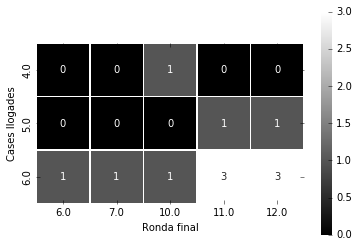

In [212]:
df_games_both = df_games_OM[(df_games_OM['control_intervention']=='BOTH') & (df_games_OM['comment']!='INCIDENT')]

cross = pd.crosstab(df_games_both.total_houses_rented,df_games_both.final_round_rent)

xticks_labels = []
yticks_labels = []
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, annot=True)

ax.set_xlabel('Ronda final')    
ax.set_ylabel('Cases llogades')

cross


In [213]:
df_games_both.groupby(['final_round_rent','total_houses_rented', 'limits', 'final_price_rent']).size()


final_round_rent  total_houses_rented  limits  final_price_rent
6.0               6.0                  4.0     628.42              1
7.0               6.0                  3.0     626.85              1
10.0              4.0                  0.0     485.05              1
                  6.0                  2.0     537.45              1
11.0              5.0                  1.0     485.05              1
                  6.0                  0.0     562.91              1
                                       1.0     536.11              2
12.0              5.0                  0.0     509.30              1
                  6.0                  0.0     534.77              2
                                       1.0     509.30              1
dtype: int64

final_round_rent,10.0,11.0,12.0
total_houses_rented,,,
5.0,1,0,1
6.0,1,6,4


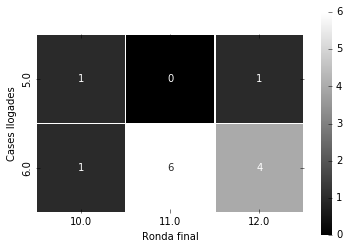

In [214]:
df_games_none = df_games_OM[(df_games_OM['control_intervention']=='NONE') & (df_games_OM['comment']!='INCIDENT')]

cross = pd.crosstab(df_games_none.total_houses_rented, df_games_none.final_round_rent)

xticks_labels = []
yticks_labels = []
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, annot=True)

ax.set_xlabel('Ronda final')    
ax.set_ylabel('Cases llogades')

cross


In [215]:
df_games_none.groupby(['final_round_rent','total_houses_rented', 'final_price_rent']).size()


final_round_rent  total_houses_rented  final_price_rent
10.0              5.0                  536.11              1
                  6.0                  592.54              1
11.0              6.0                  562.91              6
12.0              5.0                  483.84              1
                  6.0                  534.77              4
dtype: int64